# Load Data and Word-Embedding Models

In [74]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [75]:
random_vector = {}
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('random')
        if size not in random_vector:
            random_vector[size] = torch.randn(size)
        return random_vector[size]

# Vanilla RNN Implementation

In [76]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.rnn = nn.RNN(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Training and Validation Code

In [77]:

import re

def clean_word(word):
    import string
    # Removing all punctuation characters using a translation table
    clean_word = word.translate(str.maketrans('', '', string.punctuation))
    # Stripping whitespace and newline characters
    clean_word = clean_word.strip()
    
    # Convert an empty string to a whitespace of equivalent length of the original word
    if not clean_word:
        return ' ' * len(word)
    else:
        return clean_word

def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cpu', epochs=10):
    label_mapping = {"B_PRECEDENT": 0, "I_RESPONDENT": 1, "I_GPE": 2, "B_GPE": 3, "I_PROVISION": 4, "I_STATUTE": 5, "I_WITNESS": 6, "I_ORG": 7, "O": 8, "B_JUDGE": 9, "B_WITNESS": 10, "B_COURT": 11, "B_PETITIONER": 12, "I_PRECEDENT": 13, "B_CASE_NUMBER": 14, "B_OTHER_PERSON": 15, "B_PROVISION": 16, "I_COURT": 17, "I_JUDGE": 18, "I_DATE": 19, "B_ORG": 20, "B_STATUTE": 21, "I_PETITIONER": 22, "I_OTHER_PERSON": 23, "I_CASE_NUMBER": 24, "B_RESPONDENT": 25, "B_DATE": 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            # text = data["text"].split()
            pattern = r'[ ]+'
            text = re.split(pattern, data["text"])
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                # text = data["text"].split()
                pattern = r'[ ]+'
                text = re.split(pattern, data["text"])
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [78]:
def test(model, embedding_model, test_data, device='cpu'):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B_PRECEDENT": 0, "I_RESPONDENT": 1, "I_GPE": 2, "B_GPE": 3, "I_PROVISION": 4, "I_STATUTE": 5, "I_WITNESS": 6, "I_ORG": 7, "O": 8, "B_JUDGE": 9, "B_WITNESS": 10, "B_COURT": 11, "B_PETITIONER": 12, "I_PRECEDENT": 13, "B_CASE_NUMBER": 14, "B_OTHER_PERSON": 15, "B_PROVISION": 16, "I_COURT": 17, "I_JUDGE": 18, "I_DATE": 19, "B_ORG": 20, "B_STATUTE": 21, "I_PETITIONER": 22, "I_OTHER_PERSON": 23, "I_CASE_NUMBER": 24, "B_RESPONDENT": 25, "B_DATE": 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            # text = data["text"].split()
            pattern = r'[ ]+'
            text = re.split(pattern, data["text"])
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    return accuracy, f1

In [79]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [80]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 27   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [81]:
rnn_word2vec_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_word2vec_model.parameters(), lr=0.001)

In [82]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.4347, Accuracy: 0.8919, F1: 0.3527
Validation: Loss: 0.3276, Accuracy: 0.9120, F1: 0.4634
Epoch 2/10
Training: Loss: 0.3168, Accuracy: 0.9156, F1: 0.4846
Validation: Loss: 0.3088, Accuracy: 0.9177, F1: 0.4907
Epoch 3/10
Training: Loss: 0.2868, Accuracy: 0.9222, F1: 0.5311
Validation: Loss: 0.2878, Accuracy: 0.9216, F1: 0.5318
Epoch 4/10
Training: Loss: 0.2683, Accuracy: 0.9268, F1: 0.5567
Validation: Loss: 0.3181, Accuracy: 0.9172, F1: 0.5053
Epoch 5/10
Training: Loss: 0.2580, Accuracy: 0.9286, F1: 0.5718
Validation: Loss: 0.2755, Accuracy: 0.9248, F1: 0.5521
Epoch 6/10
Training: Loss: 0.2477, Accuracy: 0.9315, F1: 0.5869
Validation: Loss: 0.2820, Accuracy: 0.9253, F1: 0.5477
Epoch 7/10
Training: Loss: 0.2432, Accuracy: 0.9322, F1: 0.5986
Validation: Loss: 0.2809, Accuracy: 0.9261, F1: 0.5457
Epoch 8/10
Training: Loss: 0.2384, Accuracy: 0.9331, F1: 0.6077
Validation: Loss: 0.2826, Accuracy: 0.9262, F1: 0.5540
Epoch 9/10
Training: Loss: 0.2349, Accuracy: 0.9

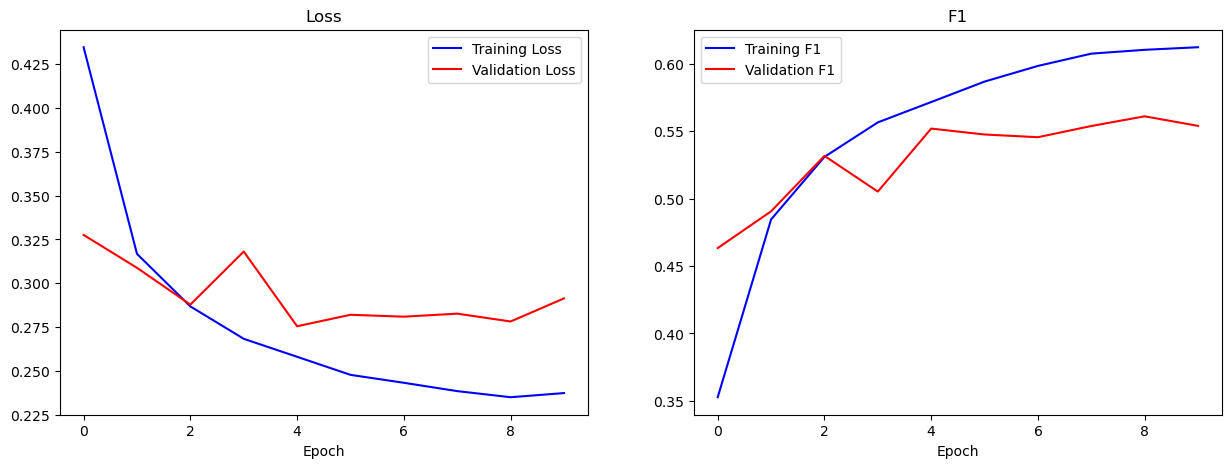

In [83]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [84]:
torch.save(rnn_word2vec_model, "t1_model1_word2vec.pt")

In [85]:
test_accuracy, test_f1 = test("t1_model1_word2vec.pt", word2vec, test_data, device='cpu')
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Vaniila RNN with Word2Vec ==> Accuracy: 0.9224, F1: 0.5425


# For GloVe Embeddings

In [86]:
rnn_glove_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_glove_model.parameters(), lr=0.001)

In [87]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_glove_model, glove, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.5736, Accuracy: 0.8581, F1: 0.1363
Validation: Loss: 0.5055, Accuracy: 0.8754, F1: 0.2058
Epoch 2/10
Training: Loss: 0.5011, Accuracy: 0.8727, F1: 0.2028
Validation: Loss: 0.4992, Accuracy: 0.8737, F1: 0.2169
Epoch 3/10
Training: Loss: 0.4827, Accuracy: 0.8762, F1: 0.2211
Validation: Loss: 0.4746, Accuracy: 0.8805, F1: 0.2340
Epoch 4/10
Training: Loss: 0.4725, Accuracy: 0.8767, F1: 0.2311
Validation: Loss: 0.4798, Accuracy: 0.8759, F1: 0.2378
Epoch 5/10
Training: Loss: 0.4739, Accuracy: 0.8758, F1: 0.2328
Validation: Loss: 0.4614, Accuracy: 0.8807, F1: 0.2566
Epoch 6/10
Training: Loss: 0.4569, Accuracy: 0.8804, F1: 0.2523
Validation: Loss: 0.4611, Accuracy: 0.8650, F1: 0.2416
Epoch 7/10
Training: Loss: 0.4539, Accuracy: 0.8819, F1: 0.2597
Validation: Loss: 0.4505, Accuracy: 0.8829, F1: 0.2631
Epoch 8/10
Training: Loss: 0.4616, Accuracy: 0.8803, F1: 0.2528
Validation: Loss: 0.4579, Accuracy: 0.8816, F1: 0.2655
Epoch 9/10
Training: Loss: 0.4480, Accuracy: 0.8

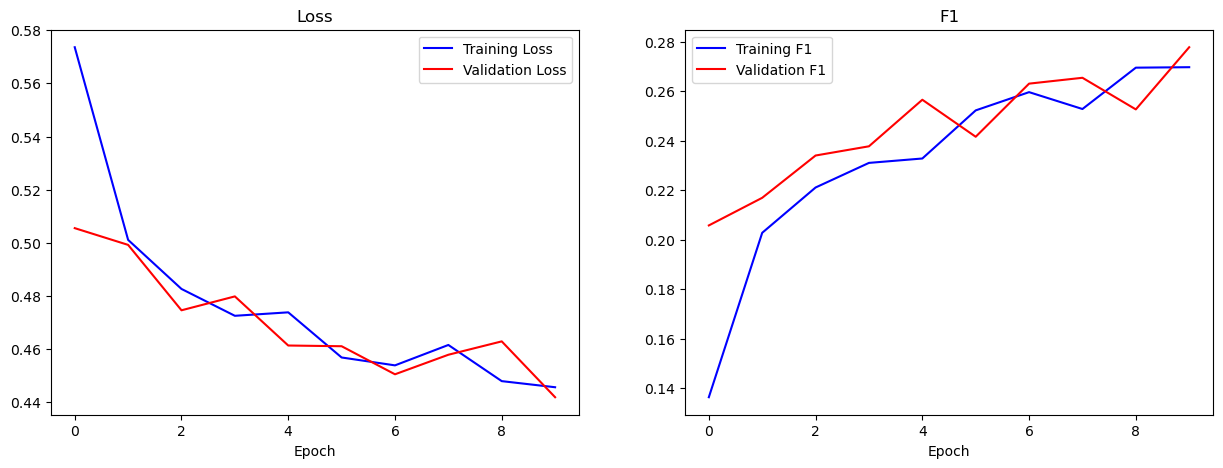

In [88]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [89]:
torch.save(rnn_glove_model, "t1_model1_glove.pt")

In [90]:
test_accuracy, test_f1 = test("t1_model1_glove.pt", glove, test_data, device='cpu')
print(("Vaniila RNN with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Vaniila RNN with GloVe ==> Accuracy: 0.8859, F1: 0.2720


# For FastText Embeddings

In [91]:
rnn_fasttext_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_fasttext_model.parameters(), lr=0.001)

In [92]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        rnn_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.4329, Accuracy: 0.8914, F1: 0.3303
Validation: Loss: 0.3219, Accuracy: 0.9114, F1: 0.4223
Epoch 2/10
Training: Loss: 0.3164, Accuracy: 0.9132, F1: 0.4434
Validation: Loss: 0.3219, Accuracy: 0.9115, F1: 0.4444
Epoch 3/10
Training: Loss: 0.2846, Accuracy: 0.9213, F1: 0.4955
Validation: Loss: 0.2887, Accuracy: 0.9225, F1: 0.4975
Epoch 4/10
Training: Loss: 0.2638, Accuracy: 0.9268, F1: 0.5264
Validation: Loss: 0.2838, Accuracy: 0.9236, F1: 0.5025
Epoch 5/10
Training: Loss: 0.2519, Accuracy: 0.9296, F1: 0.5471
Validation: Loss: 0.2771, Accuracy: 0.9261, F1: 0.5235
Epoch 6/10
Training: Loss: 0.2420, Accuracy: 0.9315, F1: 0.5584
Validation: Loss: 0.2894, Accuracy: 0.9214, F1: 0.5058
Epoch 7/10
Training: Loss: 0.2335, Accuracy: 0.9338, F1: 0.5776
Validation: Loss: 0.2696, Accuracy: 0.9279, F1: 0.5329
Epoch 8/10
Training: Loss: 0.2292, Accuracy: 0.9350, F1: 0.5867
Validation: Loss: 0.2793, Accuracy: 0.9259, F1: 0.5294
Epoch 9/10
Training: Loss: 0.2241, Accuracy: 0.9

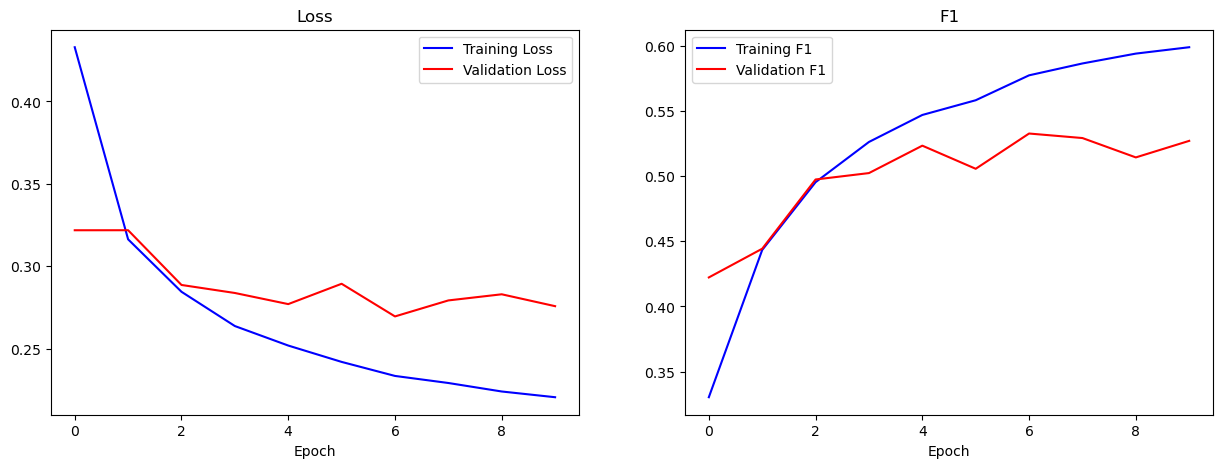

In [93]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [94]:
torch.save(rnn_fasttext_model, "t1_model1_fasttext.pt")

In [95]:
test_accuracy, test_f1 = test("t1_model1_fasttext.pt", fasttext, test_data, device='cpu')
print(("Vaniila RNN with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Vaniila RNN with FastText ==> Accuracy: 0.9254, F1: 0.5239
